# Anomaly detection

In [7]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import random
import os

from scipy.stats import multivariate_normal
from sklearn.metrics import confusion_matrix,f1_score, roc_auc_score,roc_curve
from sklearn.model_selection import train_test_split
from sklearn import preprocessing

import scipy.stats as stats
import pylab
import seaborn as sns

import sklearn
import scipy
import matplotlib


Set the Bnab type and the HIV immmune donors experiment to process

In [8]:
SEEDNUMBER=1
BNAB="gp120_CD4BS"  # The 5 bnab types are:  gp120_CD4BS     gp120_V2      gp120_V3     gp41_MPER     gp41-gp120_interface
DATAPATH="input_data/"
if not os.path.exists("output/"):
    os.mkdir("output/")
OUTPUTPATH="output/"+BNAB+"/"
if not os.path.exists(OUTPUTPATH):
    os.mkdir(OUTPUTPATH)
#here we set the HIV donors experiment to process
EXP="S4"
EXPPATH="HIVdonors_AIRR/"+EXP+"/"

# HERE to have the same color than for the DC and RF
colors = ["darksalmon", "lightsteelblue"]
customPalette = sns.set_palette(sns.color_palette(colors))


In [9]:
#some functions

def estimate_gaussian(dataset):
    mu = np.mean(dataset, axis=0)
    sigma = np.cov(dataset.T)
    return mu, sigma


def multivariate_gaussian(dataset, mu, sigma):
    p = multivariate_normal(mean=mu, cov=sigma)
    return p.pdf(dataset)


def select_threshold(probs, yval):
    tplist=[]
    fplist=[]
    validation_accuracies=[]
    validation_aucs=[]
    validation_TPs=[]
    validation_FPs=[]
    best_epsilon = 0
    best_f1 = 0
    best_tp = 0
    best_fp = sum(yval == 0)
    print("best fp is = ",best_fp)
    best_precision=0
    f = 0
    stepsize = (max(probs) - min(probs)) / 1000 
    epsilons = np.arange(min(probs), max(probs), stepsize)
    for epsilon in np.nditer(epsilons):
        predictions = (probs < epsilon)
        #print(predictions)
        tp = sum(np.logical_and(predictions == 1, yval == 1))
        fp = sum(np.logical_and(predictions == 1, yval == 0))
        fn = sum(np.logical_and(predictions == 0, yval == 1))
        tn = sum(np.logical_and(predictions == 0, yval == 0))
        validation_FPs.append(fp)
        validation_TPs.append(tp)
        fpr = fp / (fp+tn)
        if tp == 0:
            tp=0.001 #to not have a zero val
        fplist.append(fpr)
        # Precision or positive predictive value 
        # (the ability of the classifier not to label a negative sample as positive)
        precision = tp / (tp + fp)
        recall = tp / (tp + fn)
        accu = (tp+tn)/(tp+tn+fp+fn)
        validation_accuracies.append(accu)
        auc = roc_auc_score(yval,predictions)
        validation_aucs.append(auc)
        tplist.append(recall)
        f = (2 * precision * recall) / (precision + recall)
        print("For f "+ str(f) + " and epsilon "+str(epsilon))
        print("   precision= "+str(precision))
        print("   recall/TPR= "+str(recall))
        print("   FPR= "+str(fpr))
        print("   FP= "+str(fp)+"--")
        if(fp<best_fp and tp >=1):
            best_f1 = f
            best_epsilon = epsilon
            best_predictions = predictions
            best_precision = precision
            best_tp=tp
            best_fp=fp

    return best_f1, best_epsilon, tplist, fplist, best_predictions, best_precision, best_fp,best_tp,validation_accuracies,validation_aucs,validation_FPs,validation_TPs,epsilons



### Let us explore our dataset.

In [10]:
data=pd.read_csv(DATAPATH+"features_table_"+BNAB+".tsv",sep='\t')


In [11]:

data.skew()

/tmp/ipykernel_325371/2917084029.py:1: FutureWarning: Dropping of nuisance columns in DataFrame reductions (with 'numeric_only=None') is deprecated; in a future version this will raise TypeError.  Select only valid columns before calling the reduction.
  data.skew()


HCDR3.length             0.361746
hcdr3.hydrophobicity     0.701408
LCDR3.length             0.379686
mut.freq                 0.796924
fwrs.mut.freq            1.208048
VH1.lcdr3_5             22.691362
VH1-69.VK3-20.GW         0.000000
is.bnAb                 16.587123
dtype: float64

###  We normalize the data (features tables) 

In [12]:
#we used the HIV donors data too
donordata_not_normalized=pd.read_csv(EXPPATH+"AIRR_file_"+EXP+"_featuresTable.tsv",sep='\t')
data=pd.read_csv(DATAPATH+"features_table_"+BNAB+".tsv",sep='\t')
dondata = donordata_not_normalized.copy();

data_to_norm= pd.concat([data, dondata])

#we normalize by column
d = preprocessing.normalize(data_to_norm[["HCDR3.length","hcdr3.hydrophobicity","LCDR3.length","mut.freq","fwrs.mut.freq"]], axis=0) 
data_to_norm[["HCDR3.length","hcdr3.hydrophobicity","LCDR3.length","mut.freq","fwrs.mut.freq"]] = pd.DataFrame(d)
selected = dondata['sequence.id']
#now we remove the donor data
data= data_to_norm[-data_to_norm['sequence.id'].isin(selected)]
del data["sequence.id"]
data.head()


,vh.gene,HCDR3.length,hcdr3.hydrophobicity,vl.gene,LCDR3.length,mut.freq,fwrs.mut.freq,VH1.lcdr3_5,VH1-69.VK3-20.GW,is.bnAb
0,IGHV3-66,0.009344,0.009960,IGKV1-5,0.006869,0.000736,0.000869,0,0,0.0
1,IGHV4-59,0.005606,0.003703,IGKV4-1,0.006869,0.005892,0.006082,0,0,0.0
2,IGHV6-1,0.003270,0.002426,IGKV4-1,0.006869,0.000000,0.000000,0,0,0.0
3,IGHV3-48,0.009344,0.005363,IGLV3-19,0.007632,0.013256,0.013034,0,0,0.0
4,IGHV4-59,0.005606,0.009194,IGLV1-47,0.008395,0.000736,0.000869,0,0,0.0


HCDR3.length is Normally distributed

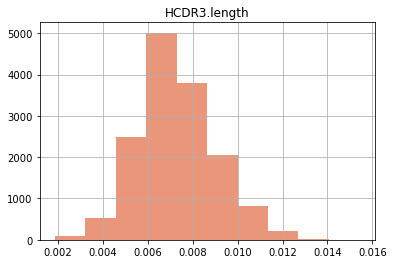

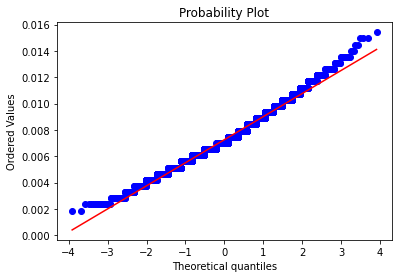

In [13]:
data["HCDR3.length"].hist()
plt.title("HCDR3.length")
plt.show()

stats.probplot(data["HCDR3.length"],plot=pylab);

LCDR3.length is Normally distributed

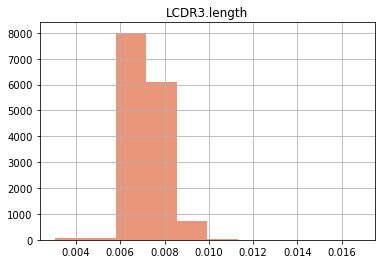

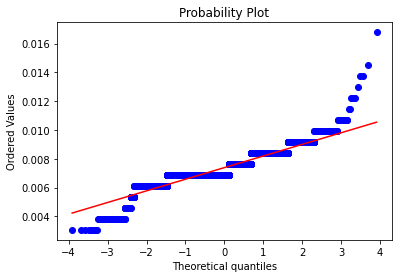

In [14]:
data["LCDR3.length"].hist()
plt.title("LCDR3.length")
plt.show()

stats.probplot(data["LCDR3.length"],plot=pylab);

HCDR3.hydrophobicity is Normally distributed

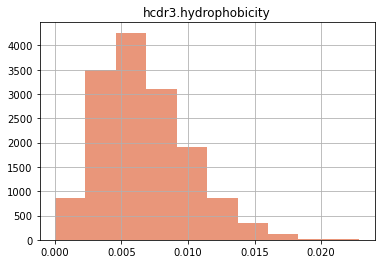

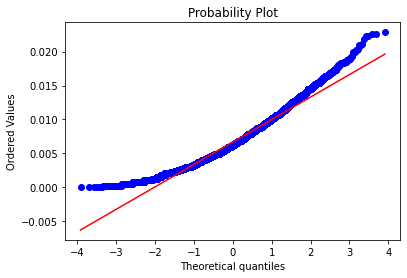

In [15]:
data["hcdr3.hydrophobicity"].hist()
plt.title("hcdr3.hydrophobicity")
plt.show()
stats.probplot(data["hcdr3.hydrophobicity"],plot=pylab);

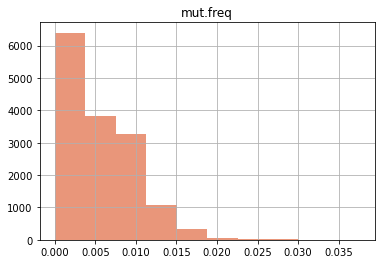

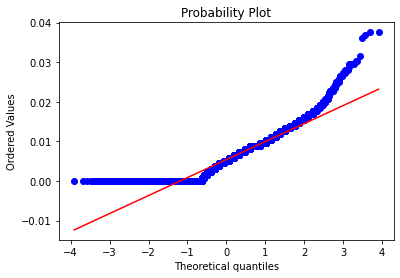

In [16]:
data["mut.freq"].hist()
plt.title("mut.freq")
plt.show()
stats.probplot(data["mut.freq"],plot=pylab);

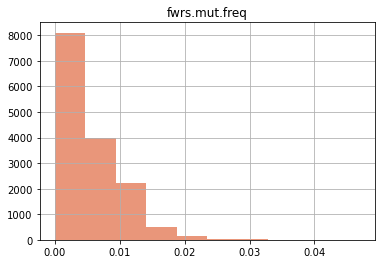

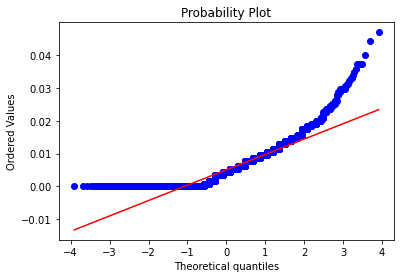

In [17]:
data["fwrs.mut.freq"].hist()
plt.title("fwrs.mut.freq")
plt.show()
stats.probplot(data["fwrs.mut.freq"],plot=pylab);

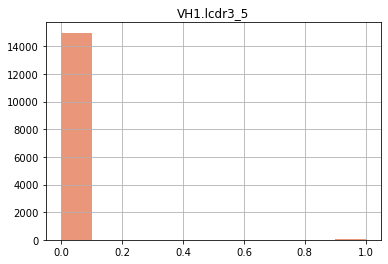

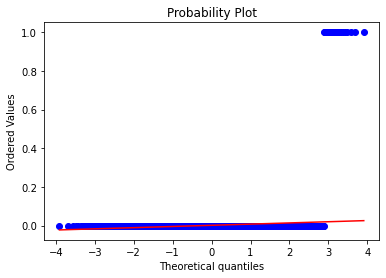

In [18]:
data["VH1.lcdr3_5"].hist()
plt.title("VH1.lcdr3_5")
plt.show()
stats.probplot(data["VH1.lcdr3_5"],plot=pylab);

We will generate random number for 0 values with SD of 0.2 and keep the value 1 as 1 to have a Gaussian distribution

/tmp/ipykernel_325371/2516742920.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data.at[index,"VH1.lcdr3_5"] =gausval[index]


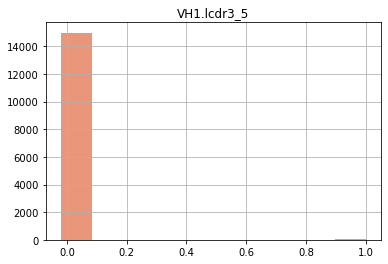

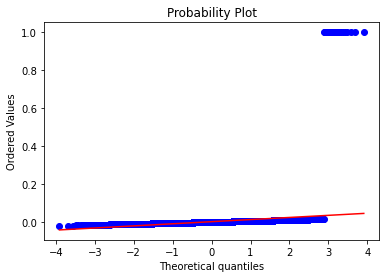

In [19]:
#make some random value with a gaussian distrib for the zero values
rng = np.random.default_rng()
gausval=rng.normal(0.0, 0.005, len(data))
for index,row in enumerate(data["VH1.lcdr3_5"]):
    if(row==0):
        data.at[index,"VH1.lcdr3_5"] =gausval[index]

data["VH1.lcdr3_5"].hist()
plt.title("VH1.lcdr3_5")
plt.show()
stats.probplot(data["VH1.lcdr3_5"],plot=pylab);


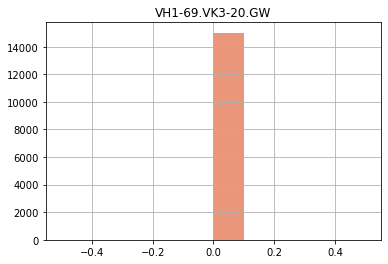

In [20]:
data["VH1-69.VK3-20.GW"].hist()
plt.title("VH1-69.VK3-20.GW")
plt.show()

Make this values as Gaussian distribution

/tmp/ipykernel_325371/298305370.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data.at[index,"VH1-69.VK3-20.GW"] =gausval[index]


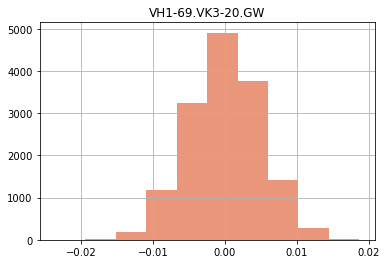

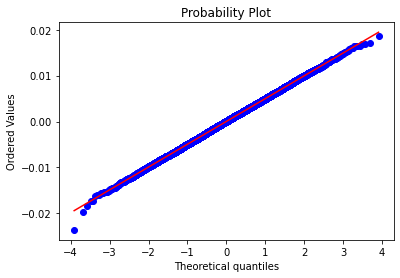

In [21]:
#make some random value with a gaussian distrib for the zero values
rng = np.random.default_rng()
gausval=rng.normal(0.0, 0.005, len(data))
for index,row in enumerate(data["VH1-69.VK3-20.GW"]):
    if(row==0):
        data.at[index,"VH1-69.VK3-20.GW"] =gausval[index]

data["VH1-69.VK3-20.GW"].hist()
plt.title("VH1-69.VK3-20.GW")
plt.show()
stats.probplot(data["VH1-69.VK3-20.GW"],plot=pylab);

Let's use only the features that are important for each antigenic site

In [22]:
# gp120_CD4BS     gp120_V2      gp120_V3     gp41_MPER     gp41-gp120_interface
if (BNAB == "gp120_CD4BS"):
    df=data[["mut.freq","fwrs.mut.freq","VH1.lcdr3_5","is.bnAb"]]

elif (BNAB == "gp41_MPER"):
    df=data[["mut.freq","fwrs.mut.freq","hcdr3.hydrophobicity","VH1-69.VK3-20.GW","is.bnAb"]]

elif (BNAB == "gp120_V2"):
    df=data[["mut.freq","fwrs.mut.freq","hcdr3.hydrophobicity","HCDR3.length","is.bnAb"]]

elif (BNAB == "gp120_V3"):
    df=data[["mut.freq","fwrs.mut.freq","hcdr3.hydrophobicity","HCDR3.length","is.bnAb"]]

elif (BNAB == "gp41-gp120_interface"):
    df=data[["mut.freq","fwrs.mut.freq","is.bnAb"]]

df.head(3)

,mut.freq,fwrs.mut.freq,VH1.lcdr3_5,is.bnAb
0,0.000736,0.000869,-0.003868,0.0
1,0.005892,0.006082,-0.007263,0.0
2,0.000000,0.000000,-0.001712,0.0


### Split the dataset into training, validation and test sets
The training dataset is only composed of NON-bNabs

In [23]:

seed=SEEDNUMBER
np.random.seed(seed)
random.seed(seed)
random_state=seed

training,test,trainingtarget,testtarget=train_test_split(df.loc[:,df.columns != "is.bnAb"],df.loc[:,"is.bnAb"],
                                                         test_size=0.2,random_state=random_state)
training,validation,trainingtarget,validationtarget=train_test_split(training,trainingtarget,
                                                                     test_size=0.25,random_state=random_state) 

#we have to remove the bNabs from the training dataset
print("number of data in the trainingtarget dataset ",len(trainingtarget))
bnab_indexes = [n for n,x in enumerate(trainingtarget) if x==1]
nobnab_indexes = [n for n,x in enumerate(trainingtarget) if x==0]
print(bnab_indexes)
print("No bnabs data are ", len(nobnab_indexes))
def remove_by_indices(iter, idxs):
    return [e for i, e in enumerate(iter) if i not in idxs]
trainingtarget=remove_by_indices(trainingtarget,bnab_indexes)
print("number of bnabs to delete from the training dataset: ",len(bnab_indexes))
print("number of data in the trainingtarget dataset ",len(trainingtarget))
print(training.shape)
train_data = np.take(training,nobnab_indexes, axis=0)
print("Data use for the training dataset: ",train_data.shape)

crossval_data=validation
crossval_data_Y =validationtarget

test_data=test
test_data_Y=testtarget


number of data in the trainingtarget dataset  9009
[158, 344, 381, 456, 685, 816, 1240, 1327, 2028, 2196, 2448, 2607, 2632, 3522, 4004, 4177, 4713, 5155, 5258, 6171, 7364, 7474, 7823, 8021, 8656, 8769]
No bnabs data are  8983
number of bnabs to delete from the training dataset:  26
number of data in the trainingtarget dataset  8983
(9009, 3)
Data use for the training dataset:  (8983, 3)


### Estimate Gaussian for the training dataset

In [24]:
mu, sigma = estimate_gaussian(train_data)
print(mu)
print(sigma)

mut.freq         0.005397
fwrs.mut.freq    0.005030
VH1.lcdr3_5      0.000301
dtype: float64
[[2.15598350e-05 2.16704700e-05 1.32964739e-06]
 [2.16704700e-05 2.36308830e-05 1.73698986e-06]
 [1.32964739e-06 1.73698986e-06 2.48122702e-04]]


### Selecting optimal value of epsilon using cross validation

best fp is =  2988
For f 0.0001333155579256099 and epsilon 0.0
   precision= 1.0
   recall/TPR= 6.666222251849876e-05
   FPR= 0.0
   FP= 0--
For f 0.45833333333333326 and epsilon 618.2882254322384
   precision= 0.3333333333333333
   recall/TPR= 0.7333333333333333
   FPR= 0.007362784471218206
   FP= 22--
For f 0.4 and epsilon 1236.5764508644768
   precision= 0.26666666666666666
   recall/TPR= 0.8
   FPR= 0.01104417670682731
   FP= 33--
For f 0.36923076923076925 and epsilon 1854.864676296715
   precision= 0.24
   recall/TPR= 0.8
   FPR= 0.012717536813922356
   FP= 38--
For f 0.3478260869565218 and epsilon 2473.1529017289536
   precision= 0.2222222222222222
   recall/TPR= 0.8
   FPR= 0.014056224899598393
   FP= 42--
For f 0.3243243243243243 and epsilon 3091.441127161192
   precision= 0.2033898305084746
   recall/TPR= 0.8
   FPR= 0.01572958500669344
   FP= 47--
For f 0.3076923076923077 and epsilon 3709.72935259343
   precision= 0.19047619047619047
   recall/TPR= 0.8
   FPR= 0.0170682730923

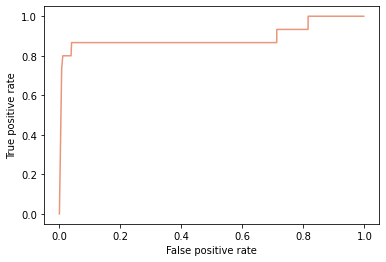

In [25]:
validation_accuracies=[]
validation_aucs=[]
validation_TPs=[]
validation_FPs=[]
p_cv = multivariate_gaussian(crossval_data,mu,sigma)
yvalues = np.reshape(crossval_data_Y, len(crossval_data_Y))
fscore, ep, tplist, fplist,predictions, prec, fp,tp,validation_accuracies,validation_aucs,validation_FPs,validation_TPs,epsilons = select_threshold(p_cv, yvalues)
print("Fscore and epsilon values:")
print(fscore, ep)
plt.plot(fplist,tplist)
# naming the x axis
plt.xlabel('False positive rate')
# naming the y axis
plt.ylabel('True positive rate')
#plt.ylim(0,1)
#plt.xlim(0,1)
auc = roc_auc_score(yvalues,predictions)
print("AUC = ",auc)
print("precision = ",prec)
print("FP = ",fp)
print("TP = ",tp)
cm=confusion_matrix(crossval_data_Y,predictions)
print(cm)
tn_v, fp_v, fn_v, tp_v = cm.ravel()
auc_v=auc
print(ep)

In [26]:
greek_letterz=[chr(code) for code in range(945,970)]
toprint=greek_letterz[4]+"= "+str(float(np.round(ep, 2)))
print(toprint)


ε= 618.29


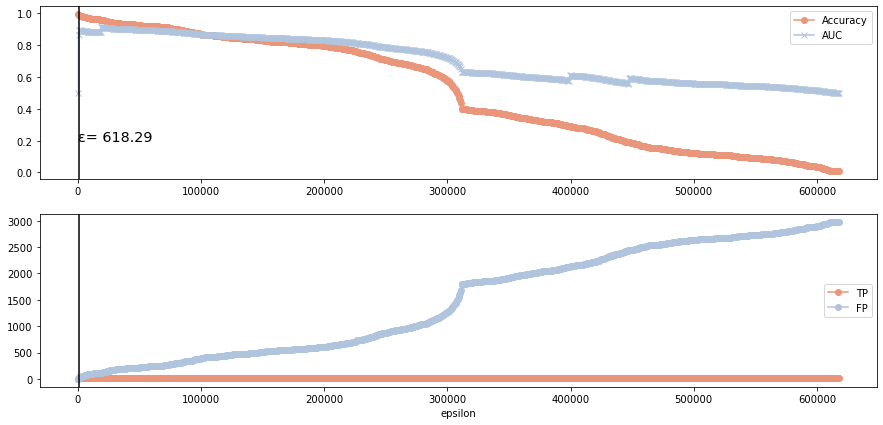

In [27]:

fig,ax=plt.subplots(2,1,figsize=(15, 7))

line1, =ax[0].plot(epsilons,validation_accuracies,marker='o',drawstyle="steps-post",label='Accuracy')
line2, = ax[0].plot(epsilons,validation_aucs,marker='x',drawstyle="steps-post",label='AUC')
ax[0].axvline(x=ep, color='black')
ax[0].text(500,0.2,toprint,fontsize='x-large')
#ax[0].set_xlabel("epsilon")
ax[0].legend(handles=[line1, line2])

line1, =ax[1].plot(epsilons,validation_TPs,marker='o',drawstyle="steps-post",label='TP')
line2, =ax[1].plot(epsilons,validation_FPs,marker='o',drawstyle="steps-post",label='FP')
ax[1].axvline(x=ep, color='black')
ax[1].set_xlabel("epsilon")
ax[1].legend(handles=[line1, line2])

#plt.show()
plt.savefig(OUTPUTPATH+'anomaly_detection_AUC_TP_FP_plots_'+BNAB+'_seed'+str(SEEDNUMBER)+'.svg', bbox_inches='tight')

#### Save the TP and FP for the validation data set into text file to compare them with the 2 other ML methods

In [28]:
#Make a big table with predicted and known bnab
# Save TP and FP in txt files to compare them with the 2 other methods
valTable= crossval_data.copy()
valTable['is_bnab']= crossval_data_Y
valTable['predicted'] = predictions
df=valTable[(valTable['predicted'] == 1) & (valTable['is_bnab'] == 0)]
print(df)
df.to_csv(OUTPUTPATH+'validation_FP_anomaly_seed'+str(SEEDNUMBER)+'.tsv', sep = "\t")
df=valTable[(valTable['predicted'] == 1) & (valTable['is_bnab'] == 1)]
print(df)
df.to_csv(OUTPUTPATH+'validation_TP_anomaly_seed'+str(SEEDNUMBER)+'.tsv', sep = "\t")

       mut.freq  fwrs.mut.freq  VH1.lcdr3_5  is_bnab  predicted
376    0.022831       0.028674     0.003762      0.0       True
12140  0.014729       0.019116     0.000655      0.0       True
13741  0.019885       0.023461     0.000418      0.0       True
6884   0.023567       0.024330     0.005218      0.0       True
7490   0.013993       0.018247    -0.008063      0.0       True
773    0.012520       0.017378    -0.000005      0.0       True
11952  0.016202       0.019985     0.000954      0.0       True
10192  0.018412       0.023461    -0.000899      0.0       True
11953  0.017675       0.022592     0.003504      0.0       True
14071  0.008838       0.007820     1.000000      0.0       True
477    0.025040       0.029543     0.004868      0.0       True
1265   0.025040       0.029543    -0.004195      0.0       True
12841  0.026513       0.026068    -0.006253      0.0       True
3085   0.022831       0.020854     0.000799      0.0       True
8686   0.016202       0.019985     0.000

### Selecting outlier datapoints from the test set

In [29]:
p = multivariate_gaussian(test_data,mu,sigma)
print(p)
outliers = np.asarray(np.where(p < ep))
predic = []
for row in p:
    if row <ep: predic.append(1)
    else: predic.append(0)
print(test_data.shape)
print(outliers[0])

cm=confusion_matrix(test_data_Y,predic)
print(cm)
tn_t, fp_t, fn_t, tp_t = cm.ravel()
auc_t= roc_auc_score(test_data_Y,predic)

[199658.82570719 244103.39229553 581985.23039964 ... 450712.03864885
 269112.46446984 491646.44475934]
(3004, 3)
[  30   84  284  322  358  412  474  495  611  747  767 1047 1048 1199
 1500 1681 1718 1822 1848 1874 2015 2031 2080 2107 2120 2128 2196 2262
 2588 2819 2856 2875]
[[2969   22]
 [   3   10]]


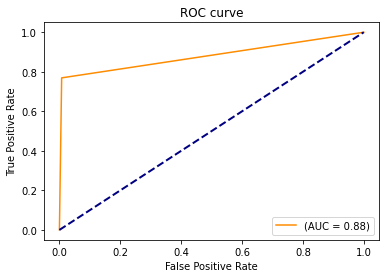

In [30]:
fpr,tpr,thresholds=roc_curve(test_data_Y,predic)

AUC=roc_auc_score(test_data_Y,predic)
auc_t = AUC

plt.plot(fpr,tpr,color="darkorange",label="(AUC = %0.2f)"%auc_t)
plt.plot([0, 1],[0, 1],color="navy",lw=2,linestyle="--")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.legend(loc="lower right")
plt.title('ROC curve')
#plt.show()
plt.savefig(OUTPUTPATH+'AnoDetec_ROCcurve_'+BNAB+'_seed'+str(SEEDNUMBER)+'.pdf', bbox_inches='tight')

### Save TP and FP into text files

In [31]:

#Make a big table with predicted and known bnab
# Save TP and FP in txt files to compare them with the 2 other methods
testTable= test_data.copy()
testTable['is_bnab']= test_data_Y
testTable['predicted'] = predic
df=testTable[(testTable['predicted'] == 1) & (testTable['is_bnab'] == 0)]
print(df)
df.to_csv(OUTPUTPATH+'test_FP_anomaly_seed'+str(SEEDNUMBER)+'.tsv', sep = "\t")
df=testTable[(testTable['predicted'] == 1) & (testTable['is_bnab'] == 1)]
#print(df)
df.to_csv(OUTPUTPATH+'test_TP_anomaly_seed'+str(SEEDNUMBER)+'.tsv', sep = "\t")


       mut.freq  fwrs.mut.freq  VH1.lcdr3_5  is_bnab  predicted
10035  0.016202       0.019985    -0.003842      0.0          1
10019  0.011047       0.015641     0.007087      0.0          1
6261   0.005892       0.000000     0.003019      0.0          1
1365   0.021358       0.023461     0.002866      0.0          1
1662   0.012520       0.017378     0.001038      0.0          1
2080   0.018412       0.022592    -0.001278      0.0          1
13180  0.011047       0.005214    -0.005699      0.0          1
6270   0.022094       0.023461    -0.009332      0.0          1
4928   0.015466       0.019985     0.002870      0.0          1
12145  0.008838       0.001738     0.013126      0.0          1
6433   0.011784       0.017378     0.001799      0.0          1
6391   0.011047       0.015641    -0.005162      0.0          1
9266   0.011784       0.006082     0.004984      0.0          1
397    0.020621       0.015641     0.000237      0.0          1
10625  0.007365       0.001738    -0.000

In [32]:
print("algo"+"\t"+"BnAb"+"\t"+"seed"+"\t"+"criterion"+"\t"+"RF.max.samples"+"\t"+"RF.max.depth"+"\t"+"TPval"+"\t"+"FPval"+"\t"+"TNval"+"\t"+"FNval"+"\t"+"AUCval"+"\t"+"TPtest"+"\t"+"FPtest"+"\t"+"TNtest"+"\t"+"FNtest"+"\t"+"AUCtest")
print("anomaly_detection"+"\t"+BNAB+"\t"+str(SEEDNUMBER)+"\tNA\tNA\tNA\t"+str(tp_v)+"\t"+str(fp_v)+"\t"+str(tn_v)+"\t"+str(fn_v)+"\t"+str(auc_v)+"\t"+str(tp_t)+"\t"+str(fp_t)+"\t"+str(tn_t)+"\t"+str(fn_t)+"\t"+str(auc_t))


algo	BnAb	seed	criterion	RF.max.samples	RF.max.depth	TPval	FPval	TNval	FNval	AUCval	TPtest	FPtest	TNtest	FNtest	AUCtest
anomaly_detection	gp120_CD4BS	1	NA	NA	NA	11	22	2966	4	0.8629852744310577	10	22	2969	3	0.88093768484942


### Now we can test some donors

In [33]:

#we take back only the donor data from the normalized data
selected = dondata['sequence.id']
donordata= data_to_norm[data_to_norm['sequence.id'].isin(selected)]
print(donordata.shape)

#make some random value with a gaussian distrib for the zero values
rng = np.random.default_rng()
gausval=rng.normal(0.0, 0.005, len(donordata))
for index,row in enumerate(donordata["VH1.lcdr3_5"]):
    if(row==0):
        donordata.at[index,"VH1.lcdr3_5"] =gausval[index]


rng = np.random.default_rng()
gausval=rng.normal(0.0, 0.005, len(donordata))
for index,row in enumerate(donordata["VH1-69.VK3-20.GW"]):
    if(row==0):
        donordata.at[index,"VH1-69.VK3-20.GW"] =gausval[index]



# we select the features depending on the epitope
if (BNAB == "gp120_CD4BS"):
    df=donordata[["mut.freq","fwrs.mut.freq","VH1.lcdr3_5"]]

elif (BNAB == "gp41_MPER"):
    df=donordata[["mut.freq","fwrs.mut.freq","hcdr3.hydrophobicity","VH1-69.VK3-20.GW"]]

elif (BNAB == "gp120_V2"):
    df=donordata[["mut.freq","fwrs.mut.freq","hcdr3.hydrophobicity","HCDR3.length"]]

elif (BNAB == "gp120_V3"):
    df=donordata[["mut.freq","fwrs.mut.freq","hcdr3.hydrophobicity","HCDR3.length"]]

elif (BNAB == "gp41-gp120_interface"):
    df=donordata[["mut.freq","fwrs.mut.freq"]]

print(df.head(3))

#we predict with the anomaly detection algo
p = multivariate_gaussian(df,mu,sigma)
print(p)
outliers = np.asarray(np.where(p < ep))
predic = []
for row in p:
    if row <ep: predic.append(1)
    else: predic.append(0)
#print(outliers[0])
print(len(outliers[0]))

valTable= df.copy()
valTable['predicted'] = predic

dataf=valTable[(valTable['predicted'] == 1) ]

if (BNAB == "gp120_CD4BS"):
    dataf=dataf[["mut.freq","fwrs.mut.freq","VH1.lcdr3_5"]]

elif (BNAB == "gp41_MPER"):
    dataf=dataf[["mut.freq","fwrs.mut.freq","hcdr3.hydrophobicity","VH1-69.VK3-20.GW"]]

elif (BNAB == "gp120_V2"):
    dataf=dataf[["mut.freq","fwrs.mut.freq","hcdr3.hydrophobicity","HCDR3.length"]]

elif (BNAB == "gp120_V3"):
    dataf=dataf[["mut.freq","fwrs.mut.freq","hcdr3.hydrophobicity","HCDR3.length"]]

elif (BNAB == "gp41-gp120_interface"):
    dataf=dataf[["mut.freq","fwrs.mut.freq"]]


#print(dataf) #to check we have the correct rows
bnab_indexes = dataf.index.to_numpy()
print("- Found indexes:")
print(bnab_indexes)
print("\nNumber of potential "+BNAB+" BnAb with donor "+EXP+": "+str(len(bnab_indexes))+"\n")
bnab_data = donordata_not_normalized.iloc[bnab_indexes]

#we write the outliers in a file with the features and the related AIRR data
if not bnab_data.empty:
    print(bnab_data)
    airr_data=pd.read_csv(EXPPATH+"AIRR_file_"+EXP+".tsv",sep='\t')
    bnab_data.rename(columns = {'sequence.id':'sequence_id'}, inplace = True)
    df_to_write= pd.merge(bnab_data,airr_data,on="sequence_id")
    df_to_write.to_csv(EXPPATH+EXP+'_potential_anomalyDetection_'+BNAB+'.tsv', sep = "\t",index=False)




(3112, 11)
   mut.freq  fwrs.mut.freq  VH1.lcdr3_5
0  0.000736       0.000869     0.004617
1  0.005892       0.006082    -0.014018
2  0.000000       0.000000    -0.003140
[344096.17270384 383018.02768172 305260.51156519 ... 300120.40097078
 486647.71481872 439565.71227545]
38
- Found indexes:
[ 121  225  289  306  361  376  397  477  597  773  774  822  979 1123
 1179 1264 1265 1337 1365 1464 1481 1616 1658 1662 1695 1789 1813 1850
 1916 2080 2235 2236 2614 2693 2975 3066 3070 3085]

Number of potential gp120_CD4BS BnAb with donor S4: 38

                   sequence.id       vh.gene  HCDR3.length  \
121    M-1266-M-K-S4-2302-P4-1      IGHV4-31            16   
225   M-2184-G1-L-S4-2302-P4-1    IGHV1-69-2            16   
289     M-207-M-L-S4-2302-P4-1      IGHV4-34            15   
306    M-1586-X-K-S4-2302-P4-1       IGHV1-2            16   
361   M-1443-A1-K-S4-2302-P4-1      IGHV3-30            16   
376    M-3148-M-L-S4-2302-P4-1      IGHV3-73            12   
397    M-1814-M-K-S4-

/tmp/ipykernel_325371/3362587217.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  donordata.at[index,"VH1.lcdr3_5"] =gausval[index]
/tmp/ipykernel_325371/3362587217.py:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  donordata.at[index,"VH1-69.VK3-20.GW"] =gausval[index]
/tmp/ipykernel_325371/3362587217.py:83: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.